-----------
# <span style="color:blue">Classification: Using Machine Learning to Identify Device Types</span>
-----------

## The Purpose Of This Notebook:
This notebook is meant as a tutorial for applying machine learning techniques to a real world problem. Most notebooks delve deep into the math of data science or deep into the inner workings of parallel processing units. The main goal of this notebook is to define and demonstrate what machine learning is and the steps that a user needs to take to apply machine learning to a real world problem. What we want to provide you in this notebook is:
- A demonstration of how machine learning can be applied to a real world problem
- The process it takes to get data to a point where M/L will work for you
- The steps needed to create a M/L model for classification

This is a beginner tutorial. There is no expectation that people using this notebook will require any advanced education in math, or a deep understanding of parallel processing systems, or experience in python. However, we will use all three...and we will try to make it fun :)

## The Challenge 
Despite the variety of information provided by packet capture data, it fails to provide accurate information for the type of the device participating in communication. Knowledge of the device type for cyber security purposes can be crucual. This information can be indirectly present in patterns exhibited by a device in network communicaitions. <b>Our challenge is to build a machine learning model that accuratley predicts a <i>device type</i>.</b>

## Overview

This tutorial is structured as follows:

- <b>Environment Check and Setting the Data Path:</b> in this section we will load all the python modules we need for this notebook.
- <b>Background:</b> in this section we discuss what we are trying to do, will explain a little about PCAP and why we are using it.
- <b>Big Data and Data Science:</b> in this section we will explain how ML works and the origin of the data we are going to use in this exercise.
- <b>Data Exploration:</b> we will explore our data set in order to understand which variables can be used to support our ML model.
- <b>Model Building:</b> in this section we will build aclassification model using XGBoost. 
- <b>Conclusion:</b> we will wrap it up with some conclusions derived from this tutorial.
- <b>Acknowledgments</b>


-----------
# Let's Get Started
-----------

## The Environment and Data Path 
For this tutorial we are using GPUs to accelerate data processing and build machine learning (ML) models. We are using [Nvidia](https://www.nvidia.com/en-us/) GPUs and GPU related software. CUDA is the computing and programming platform, provided by Nvidia that we are using for a high level of parallism and GPU acceleration to speed up data processing and model optimization. We are also using the [RAPIDS](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science) package which provides a level of abstraction from the GPUs for easier development (Nvidia has already optimized algorithm interaction with their GPUs so we don't have to do it). 

We are using AWS EC2 for our analytics environment. A link to the environment setup and configuration can be found [here](https://gitlab.com). The configuration provides a Jupyter Notebooks environment with pre-installed machine learning libraries on a GPU instance where we will develop, train, test, and deploy our machine learning models.

We will be developing this model using Python.

### Checking the Environment
The following command executes on your machine instance to ensure you have an available GPU to process the training, test, and validation of the predictive model.

In [1]:
!nvidia-smi 

Wed Jun 10 18:34:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   45C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Let's Set Our Data Path 
We can do this by creating variables and setting the locations where our data resides. In our case the data sources are ***files*** which are located in `data/` directory:

In [2]:
DATA_PATH = "data/"
DATA_PCAP = DATA_PATH + "small_sample.pcap"
DATA_SOURCE = DATA_PATH + "conn.log"
DATA_LABELS = DATA_PATH + "lab_mac_labels_cats.csv"

In [3]:
import warnings
warnings.filterwarnings("ignore")

------------
## Background

Today, organizations collect vast amounts of network traffic and network metadata. As the volume of data collected and velocity at which it's collected continue to increase, security analysts and forensic investigators require fast triage, processing, modeling, and visualization capabilities. Using the [RAPIDS](https://rapids.ai) suite of open-source software, we demonstrate how to:

1. Triage and perform data exploration,
2. Model network data as for classification, and
3. Predict a "device type" based upon data collected in a PCAP file.

We will soon start applying machine learning to the problem of device classification for network traffic data using a GPU-accelerated computing environment. But before we begin, let's define a few terms and scope the problem we are trying to address. First let's set the scenario by describing some network data...



#### Types of Network Data
The most detailed type of data that is typically collected on a network is full Packet CAPture (PCAP) data. This information is detailed and contains everything about the communication, including: source address, destination address, protocols used, bytes transferred, and even the raw data (e.g., image, audio file, executable). PCAP data is fine-grained, meaning that there is a record for each frame being transmitted. A typical communication is composed of many individual packets/frames.

If we aggregate PCAP data so that there is one row of data per communication session, we call that flow level data. A simplified example of this relationship is shown in the figure below.

![PCAP_flow_relationship](../images/pcap_vs_flow.png "PCAP vs FLOW")

Again, despite the variety of information provided by packet capture data, it fails to provide accurate information for the type of the device participating in communication. Machine learning is a viable option to extract this information.

### Definitions
Let's go over a few terms just to make sure we are all on the same page as we begin to delve into what it will take when creating a machine learned model:

- <b>Machine Learning:</b> is the scientific study of algorithms and statistical models that computer systems use to perform a specific task without using explicit instructions, relying on patterns and inference instead. It is seen as a subset of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to perform the task. 
- <b>Algorithm:</b> In mathematics and computer science, an algorithm is a finite sequence of well-defined, computer-implementable instructions, typically to solve a class of problems or to perform a computation. Algorithms are always unambiguous and are used as specifications for performing calculations, data processing, automated reasoning, and other tasks.The types of machine learning algorithms differ in their approach, the type of data they input and output, and the type of task or problem that they are intended to solve.
- <b>Classification:</b> In machine learning, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or inputs) whose category membership (output) is known. An example is assigning a given animal to the "cat" or "dog" class. In  machine learning, classification is considered an instance of supervised learning, i.e., learning where a training set of correctly identified inputs with known corresponding outputs is available.
- <b>Supervised Learning:</b> Supervised learning algorithms build a mathematical model of a set of data that contains both the inputs and the desired outputs. The data is known as training data, and consists of a set of training examples. Each training example has one or more inputs and the desired output, also known as a supervisory signal. <i><b>Unsupervised learning</b></i> algorithms take a set of data that contains only inputs, and find structure in the data, like grouping or clustering of data points. The algorithms, therefore, learn from test data that has not been labeled, classified or categorized.
- <b>Labeled Data:</b> Labeled data is a group of records that have been tagged with one or more labels. Labeling typically takes a set of unlabeled data and augments each piece of that unlabeled data with meaningful tags that are informative. For example, labels might indicate whether a photo contains a horse or a cow, which words were uttered in an audio recording, what type of action is being performed in a video, what type of device is present in your network, etc. Well labeled data provides the foundation or "ground truth" of your data set and the ability for your alogorithm to accuratley predict outcomes.
- <b>XGBoost:</b> XGBoost is a form of the gradient boosting technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. XGBoost is what we will use to perform our prediction of the device type on your network.<i>Like I said...no math :)</i>
<br><br>
------------
------------


>Before we get into the detailed steps of developing our ML model, let's talk about a practical approach to ML. It's all about getting the data right. It's about 80% of your effort. It's all about <b>Big Data, Statistical Analysis and Data Science</b>. So let's take a little time to discuss these techniques. 


-----------
-----------
<br><br>
## Big Data, Statistical Analysis and Data Science

The availability of high quality data is vital for building a good predictive model. To achieve a "pristine, well curated" data set requires a tremendous effort. The difference between a good data set and a well curated data set is how accurately labled the data set is. Data labeling usually requires a lot of effort along with fair amount subject matter experts. To create a dataset for network data classification tasks it is even more challenging, as it requires a controlled experimental environment, where network, hardware and software configuration settings are very well known. 

The role and importance of the labeled network data can be grasped from the following diagram. Let's walk through the steps we need follow in order to achieve a pristine, well currated data set.

![ML data pipeline](../images/ACAI_Data_Flow_Diagram.png "")

## Let's break down the diagram and explain each of its pieces and how the real world <b><i>process</i></b> actually works.

The <b>"BIG DATA"</b> block represents the collection of all data within an environment, either from a network device, application, or a system. This data is collected using many different methods - network and application logs, server and system logs, RDBMSs, log aggregatio tools, etc. As we have all probably experienced, the vast amounts of data collected in the cyber security space can be overwhelming. And not all of the data may be relevent to the questions we are being asked to answer. It is important to understand the Big Data is not an application or a system. It is a concept, a methodology, used to standardize the description of data as it enters your environment. Big Data is generally described using the 5 V's: 
 - <b>Volume</b> - Sheer size of the data being generated every second 
 - <b>Value</b> - Identification of useful data
 - <b>Velocity</b> -  Speed at which data is being created and changes are occuring
 - <b>Variety</b> -  Structured, semi-structure, unstructured, probablistic data
 - and <b>Veracity</b> - Quality and accuracey of data
 
 <i>Veracity</i>, most important of the Vs, defines the trustworthiness of the data. Organizations should have a clear picture of how data was received, where data resides, where it’s been, to where it moves, who is using it, and for what purposes. To identify the veracity of data, a SME will generally "tag" the data with a lable noting is quality and accuracy. We can also extend tagging to include whether a record can be labled as good/bad, true/false. pass/fail, truth/lie. But the tags do not have to always be binary. 

We can use <b>labels</b> in our example here to tag a record with a specific device type. Labels are critical in classification models. The more accurate our labeling, the more precision we will have in predicting a device type on our network. This brings us to the second majow block in the diagram, "Control Environment". 

The <b>"Control Environment"</b> represents an environment within an organization where all data elements are considered ground-truth. Meaning, all of the data generated or received and collected in the environment is known to be the truth. The control environment does not interact with the real world in any way, yet it simulates all real-world activities. In this environment, because all elements of the data are known and all of the behavior of those elements is known, we can monitor and record the patterns of the data as it is generated and changes over time. For the challenge we face in this class, we have used a data set from a controlled environment that recorded the behavior of 31 IOT devices, to include the device type. We use the data from this environment to help us create a classification model that will predict the "type" of device, when the type is not captured in our real-world logs. 

SMEs can use the data from a control environment, along with sampling data from the real-world and applying manual techniques to identify a device type, to label records received from PCAP files. This labled data set based upon the control environment and the input form the SMEs becomes our  <b>"well-curated data set:</b>. This is the data that we use to feed our "Data Science" block.

The <b>"Data Science"</b> block in the diagram is where the Data Scientist applys statistical analysis techniques and machine learning algorithms to create a predictive model. Depending upon the types of questions that are being asked, the Data Scientist will use a variety of techniques to determine the best way to answer the question (e.g., Classification, Categorization, Anomaly Detection, Object Recognition, etc). <i>The predictive answers to questions is only as good as the ground-truth of the curated data set</i>. Once a model is created, the Data Scientist will work with DEV/SEC/OPS teams to operationalize the model - put the model into production and make it accesible to applications or systems. This brings us to the last block in our diagram, "Visualization/Operationalization".

<b>"Visualization/Operationalization"</b> is about getting the model into production. In our challenge here, that would mean creating an precise enough model that it can predict accuatley the type of device in our network without knowing from the PCAP file the actual device type. If we can create that model, we should be able to read PCAP files and determine the type of device that is generating the network traffic, without human intervention. 
    

---------
### Tutorial Data

Based upon everything we just learned about creating a well curated data set and for the sake of simplicity, we will use data from the University of New South Wales. The team of researchers at UNSW established an experimental network which included cameras, lights, plugs, motion sensors, appliances, and health-monitors. Using this controlled environment, they [collected data of IoT data from 31 IoT devices for almost half a year](http://149.171.189.1). They also kept a detailed [list of devices by MAC address](http://149.171.189.1/resources/List_Of_Devices.txt), so we have ground-truth with respect to each IoT device's behavior on the network.


---------
# Now let's really get started!

>REMINDER: our <b><i>challenge</i></b> for this notebook is to accuratley predect and identify a device type on our network by observing its presence in a PCAP file.


## Data Investigation

Let's first see some of the data. We'll load a PCAP file in using Scapy. Scapy is a Python program that enables the user to send, sniff and dissect and forge network packets. We use Scapy to read from a PCAP file.

In [4]:
from scapy.all import *
cap = rdpcap(DATA_PCAP) #remember DATA_PCAP is the small_sample.pcap file we loaded earlier.

In [5]:
eth_frame = cap[40]
ip_pkt = eth_frame.payload
segment = ip_pkt.payload
data = segment.payload

In [6]:
eth_frame.show()

###[ Ethernet ]### 
  dst       = 14:cc:20:51:33:ea
  src       = 30:8c:fb:2f:e4:b2
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 142
     id        = 55221
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = tcp
     chksum    = 0x7aab
     src       = 192.168.1.106
     dst       = 52.87.241.159
     \options   \
###[ TCP ]### 
        sport     = 40767
        dport     = https
        seq       = 91356683
        ack       = 679917399
        dataofs   = 8
        reserved  = 0
        flags     = PA
        window    = 2549
        chksum    = 0xa522
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None), ('Timestamp', (23326618, 4049741123))]
###[ Raw ]### 
           load      = '\x17\x03\x01\x00 I\x96\x06t=OO,X\x82\xe5\x85\x8e.\xd4Y\xecy\xb0\xce%p\xca\x97\x8e^\x1e_\xc4\xe7\xc4\\\x17\x03\x01\x000"\xe4\x7f\x8cNg\xe6h\xaaqm*3\xdbf\xce\xb2J\x93SH\xf87\x94?X"!\xe5\x88\xfe\xd2?5\xa

There's really a lot of features there. In addition to having multiple layers (which may differ between packets), there are a number of other issues with working directly with PCAP. Often the payload (the `Raw` section above) is encrypted, rendering it useless. The lack of aggregation also makes it difficult to differentiate between packets. What we really care about for this application is what a *session* looks like. In other words, how a Roku interacts with the network is likely quite different than how a Google Home interacts. 

To save time for the tutorial, all three weeks of PCAP data have already been transformed to flow data, and we can load that in to a typical Pandas dataframe. Due to how the data was created, we have a header row (with column names) as well as a footer row. We've already removed those rows, so nothing to do here.

In [7]:
import cudf as cd
import pandas as pd
import numpy as np
from numpy import dtype
#import nvstrings
from collections import OrderedDict

We can look at what this new aggregated data looks like, and get a better sense of the columns and their data types. Let's do this the way we're familiar with, using Pandas.

In [9]:
pdf = pd.read_csv(DATA_SOURCE, delimiter='\t')

In [10]:
pdf.head()

ts                 uid      id.orig_h  id.orig_p      id.resp_h  \
0  1.474553e+09   CIlOTU4kRBDOEJ2zf  192.168.1.241      61725    192.168.1.1   
1  1.474553e+09  CmV0US1aCCPzrVRz36  192.168.1.193       4425  192.168.1.223   
2  1.474553e+09  CEXvDL2UPDYnBDtd6h  192.168.1.193       4426  192.168.1.223   
3  1.474553e+09  CEXDAD42Irgl4M5go8  192.168.1.193       4977  192.168.1.249   
4  1.474553e+09  CW1YbA2fZzHrztJ0rl  192.168.1.193       4978  192.168.1.249   

   id.resp_p proto service  duration orig_bytes  ... local_resp missed_bytes  \
0         53   udp     dns         -          -  ...          -            0   
1      49153   tcp    http  0.008820        196  ...          -            0   
2      49153   tcp    http  0.008664        198  ...          -            0   
3      49152   tcp    http  0.020995        186  ...          -            0   
4      49152   tcp    http  0.018730        186  ...          -            0   

    history orig_pkts  orig_ip_bytes resp_pkts  resp_ip_bytes  tunnel_parents  \
0        Dc         1             74         0              0               -   
1  ShADadfF         5            464         5            461               -   
2  ShADadfF         5            466         5            461               -   
3  ShADadfF         5            454         5           1438               -   
4  ShADadfF         5            454         5           1438               -   

        orig_l2_addr       resp_l2_addr  
0  70:ee:50:18:34:43  14:cc:20:51:33:ea  
1  ec:1a:59:83:28:11  ec:1a:59:79:f4:89  
2  ec:1a:59:83:28:11  ec:1a:59:79:f4:89  
3  ec:1a:59:83:28:11  00:16:6c:ab:6b:88  
4  ec:1a:59:83:28:11  00:16:6c:ab:6b:88  

[5 rows x 23 columns]

That's Pandas, and we could certinaly continue the analysis there if we wanted. But what about  [cuDF](https://github.com/rapidsai/cudf)? Let's pivot to that for the majority of this tutorial.


In [11]:
raw_cdf = cd.io.csv.read_csv(DATA_SOURCE, delimiter='\t',na_values='-')

In [12]:
raw_cdf.dtypes

ts                float64
uid                object
id.orig_h          object
id.orig_p           int64
id.resp_h          object
id.resp_p           int64
proto              object
service            object
duration          float64
orig_bytes        float64
resp_bytes        float64
conn_state         object
local_orig           int8
local_resp           int8
missed_bytes        int64
history            object
orig_pkts           int64
orig_ip_bytes       int64
resp_pkts           int64
resp_ip_bytes       int64
tunnel_parents       int8
orig_l2_addr       object
resp_l2_addr       object
dtype: object

Those data types seem right. Let's see what this data looks like now that it's in cuDF.

In [13]:
raw_cdf.head()

ts                 uid      id.orig_h  id.orig_p      id.resp_h  \
0  1.474553e+09   CIlOTU4kRBDOEJ2zf  192.168.1.241      61725    192.168.1.1   
1  1.474553e+09  CmV0US1aCCPzrVRz36  192.168.1.193       4425  192.168.1.223   
2  1.474553e+09  CEXvDL2UPDYnBDtd6h  192.168.1.193       4426  192.168.1.223   
3  1.474553e+09  CEXDAD42Irgl4M5go8  192.168.1.193       4977  192.168.1.249   
4  1.474553e+09  CW1YbA2fZzHrztJ0rl  192.168.1.193       4978  192.168.1.249   

   id.resp_p proto service  duration orig_bytes  ... local_resp missed_bytes  \
0         53   udp     dns      null       null  ...       null            0   
1      49153   tcp    http   0.00882      196.0  ...       null            0   
2      49153   tcp    http  0.008664      198.0  ...       null            0   
3      49152   tcp    http  0.020995      186.0  ...       null            0   
4      49152   tcp    http   0.01873      186.0  ...       null            0   

    history orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  \
0        Dc         1             74          0              0   
1  ShADadfF         5            464          5            461   
2  ShADadfF         5            466          5            461   
3  ShADadfF         5            454          5           1438   
4  ShADadfF         5            454          5           1438   

   tunnel_parents       orig_l2_addr       resp_l2_addr  
0            null  70:ee:50:18:34:43  14:cc:20:51:33:ea  
1            null  ec:1a:59:83:28:11  ec:1a:59:79:f4:89  
2            null  ec:1a:59:83:28:11  ec:1a:59:79:f4:89  
3            null  ec:1a:59:83:28:11  00:16:6c:ab:6b:88  
4            null  ec:1a:59:83:28:11  00:16:6c:ab:6b:88  

[5 rows x 23 columns]

#### Spitting Data into Originator and Responder dataframes

We now have netflow that has one row per (sessionized) communication between an originator and responder. In order to classify an individual device, we will create features for each MAC address, characterizing its network activity as originator using orig_bytes, orig_pkts, orig_ip_bytes fields, and responder using resp_bytes, resp_pkts, resp_ip_bytes. For the binning the in next section we need to split the data into separate data sets for originator and responder. 

Along the way, we drop some irrelevant data which miss proper labels.

In [14]:
orig_comms_cdf = raw_cdf.loc[raw_cdf.orig_l2_addr.isnull() == False,
    ['ts','id.orig_h','id.orig_p','proto','service','duration',
                    'orig_bytes','orig_pkts','orig_ip_bytes','orig_l2_addr']]

In [15]:
resp_comms_cdf = raw_cdf.loc[raw_cdf.resp_l2_addr.isnull() == False,
                         ['ts','id.resp_h','id.resp_p','proto','service','duration',
                             'resp_bytes','resp_pkts','resp_ip_bytes','resp_l2_addr']]

### Binning the Data and Aggregating the Features


We need to perform one last stop to arrive to our training dataset. To properly merge our separate dataframe for originator/responder traffic, we need to bin the data by time. This also may help our ML algorithm as a single communication may not be an accurate representation of how a device typically acts in its environment. Namely, any IoT device have various modes it could operate in, such as "setting up","firmware update","normal operation","data upload", etc. Therefore, any single communication may not be an accurate representation of the overall pattern of the device activity. Aggregation, assumed by binning may or may not help our learning algorithm, so it is useful to explore which time binning works better. 

It also would be useful to investigate what the average duration of connection is relative to how many connections per time across various time granularities. With that said, we'll just choose a time bin of 1 hour to begin with. In order to bin, we'll use the following formula:

$$\text{time_bin}=\left\lfloor{\frac{ts}{\Delta t_{bin}*60}}\right\rfloor$$

In [16]:
import math
mins_per_bin = 10.0
resp_comms_cdf['time_bin'] = resp_comms_cdf['ts'].applymap(lambda x: math.floor(x/(60*mins_per_bin))).astype(int)
orig_comms_cdf['time_bin'] = orig_comms_cdf['ts'].applymap(lambda x: math.floor(x/(60*mins_per_bin))).astype(int)

In [17]:
resp_comms_cdf.head()

ts      id.resp_h  id.resp_p proto service  duration resp_bytes  \
0  1.474553e+09    192.168.1.1         53   udp     dns      null       null   
1  1.474553e+09  192.168.1.223      49153   tcp    http   0.00882      193.0   
2  1.474553e+09  192.168.1.223      49153   tcp    http  0.008664      193.0   
3  1.474553e+09  192.168.1.249      49152   tcp    http  0.020995     1170.0   
4  1.474553e+09  192.168.1.249      49152   tcp    http   0.01873     1170.0   

   resp_pkts  resp_ip_bytes       resp_l2_addr  time_bin  
0          0              0  14:cc:20:51:33:ea   2457588  
1          5            461  ec:1a:59:79:f4:89   2457588  
2          5            461  ec:1a:59:79:f4:89   2457588  
3          5           1438  00:16:6c:ab:6b:88   2457588  
4          5           1438  00:16:6c:ab:6b:88   2457588

We also have to make a choice about how we'll aggregate the binned data. One of the simplest ways is to sum the bytes and packets. There are really two choices for bytes, `bytes` and `ip_bytes`. With Bro, `bytes` is taken from the TCP sequence numbers and is potentially inaccurate, so we select `ip_bytes` instead for both originator and responder. We'll also use the sum of the number of packets.

In [18]:
orig_time_bin_cdf = orig_comms_cdf[['orig_bytes','orig_pkts','orig_ip_bytes','orig_l2_addr','time_bin']]\
                            .groupby(['orig_l2_addr','time_bin'])\
                            .agg({'orig_bytes':'sum',
                                  'orig_pkts':'sum',
                                  'orig_ip_bytes':'sum'}).reset_index()

resp_time_bin_cdf = resp_comms_cdf[['resp_bytes','resp_pkts','resp_ip_bytes','resp_l2_addr','time_bin']]\
                            .groupby(['resp_l2_addr','time_bin'])\
                            .agg({'resp_bytes':'sum',
                                  'resp_pkts':'sum',
                                  'resp_ip_bytes':'sum'}).reset_index()

In the cell below we merge the originator and responder dataset into one matching rows by MAC address and the time bin.

In [19]:
time_bin_cdf = cd.merge(orig_time_bin_cdf.rename({'orig_l2_addr':'mac'}),
                        resp_time_bin_cdf.rename({'resp_l2_addr':'mac'}),
         on=['mac','time_bin'],
        how='outer')

In [20]:
time_bin_cdf.head()

mac  time_bin orig_bytes orig_pkts orig_ip_bytes resp_bytes  \
0  01:00:5e:00:00:fb   2457662       null      null          null        0.0   
1  01:00:5e:00:00:fb   2457663       null      null          null        0.0   
2  01:00:5e:00:00:fb   2457664       null      null          null       null   
3  01:00:5e:00:00:fb   2457666       null      null          null        0.0   
4  01:00:5e:00:00:fb   2457669       null      null          null       null   

   resp_pkts  resp_ip_bytes  
0          0              0  
1          0              0  
2          0              0  
3          0              0  
4          0              0

### Adding ground truth labels back to the data

We'll need labels for our classification task, so we've already prepared a file with those labels.

In [21]:
labels_cdf = cd.io.csv.read_csv(DATA_LABELS, delimiter=',')

In [22]:
labels_cdf

device                mac connection  \
0                        Smart Things  d0:52:a8:00:67:5e      Wired   
1                         Amazon Echo  44:65:0d:56:cc:d3   Wireless   
2                     Netatmo Welcome  70:ee:50:18:34:43   Wireless   
3      TP-Link Day Night Cloud camera  f4:f2:6d:93:51:f1   Wireless   
4                    Samsung SmartCam  00:16:6c:ab:6b:88   Wireless   
5                             Dropcam  30:8c:fb:2f:e4:b2   Wireless   
6                      Insteon Camera  00:62:6e:51:27:2e     Wired    
7                    unknown device 1  e8:ab:fa:19:de:4f   Wireless   
8         Withings Smart Baby Monitor  00:24:e4:11:18:a8      Wired   
9                  Belkin Wemo switch  ec:1a:59:79:f4:89   Wireless   
10                 TP-Link Smart plug  50:c7:bf:00:56:39   Wireless   
11                              iHome  74:c6:3b:29:d7:1d   Wireless   
12          Belkin wemo motion sensor  ec:1a:59:83:28:11   Wireless   
13           NEST Protect smoke alarm  18:b4:30:25:be:e4   Wireless   
14            Netatmo weather station  70:ee:50:03:b8:ac   Wireless   
15               Withings Smart scale  00:24:e4:1b:6f:96   Wireless   
16      Blipcare Blood Pressure meter  74:6a:89:00:2e:25   Wireless   
17   Withings Aura smart sleep sensor  00:24:e4:20:28:c6   Wireless   
18        Light Bulbs LiFX Smart Bulb  d0:73:d5:01:83:08   Wireless   
19                      Triby Speaker  18:b7:9e:02:20:44   Wireless   
20               PIX-STAR Photo-frame  e0:76:d0:33:bb:85   Wireless   
21                         HP Printer  70:5a:0f:e4:9b:c0   Wireless   
22                 Samsung Galaxy Tab  08:21:ef:3b:fc:e3   Wireless   
23                       Nest Dropcam  30:8c:fb:b6:ea:45   Wireless   
24                      Android Phone  40:f3:08:ff:1e:da   Wireless   
25                             Laptop  74:2f:68:81:69:42   Wireless   
26                            MacBook  ac:bc:32:d4:6f:2f   Wireless   
27                      Android Phone  b4:ce:f6:a7:a3:c2   Wireless   
28                             IPhone  d0:a6:37:df:a1:e1   Wireless   
29                     MacBook/Iphone  f4:5c:89:93:cc:85   Wireless   
30  TPLink Router Bridge LAN (Gateway  14:cc:20:51:33:ea      Wired   

       category  category_id  
0           Hub            6  
1       Speaker           11  
2        Camera            1  
3        Camera            1  
4        Camera            1  
5        Camera            1  
6        Camera            1  
7        Device            3  
8        Camera            1  
9        Switch           12  
10       Switch           12  
11        Audio            0  
12       Switch           12  
13  Environment            4  
14       Device            3  
15      Fitness            5  
16      Fitness            5  
17      Fitness            5  
18     Lighting            7  
19      Speaker           11  
20       Device            3  
21      Printer            9  
22        Phone            8  
23       Camera            1  
24        Phone            8  
25     Computer            2  
26     Computer            2  
27        Phone            8  
28        Phone            8  
29     Computer            2  
30       Router           10

We now perform a series of merges to add the ground truth data (categoryID) back to the dataset. 

In [23]:
#add labels
time_bin_cdf = cd.merge(time_bin_cdf,labels_cdf[['mac','category_id']],on='mac',how='left')
time_bin_cdf = time_bin_cdf[~time_bin_cdf.category_id.isnull()]

In [24]:
time_bin_cdf.head()

mac  time_bin orig_bytes  orig_pkts  orig_ip_bytes  \
54080  70:5a:0f:e4:9b:c0   2460208       null         30           2160   
54081  70:5a:0f:e4:9b:c0   2460209       null         26           1872   
54082  70:5a:0f:e4:9b:c0   2460210       null         28           2016   
54083  70:5a:0f:e4:9b:c0   2460211       null         30           2160   
54084  70:5a:0f:e4:9b:c0   2460212       null         30           2160   

      resp_bytes resp_pkts resp_ip_bytes  category_id  
54080       null      null          null            9  
54081       null      null          null            9  
54082       null      null          null            9  
54083       null      null          null            9  
54084       null      null          null            9

We will use `orig_category_id` columns as our labels. However, in some cases when there was no originating traffic for a device in a time bin, but responding traffic was present, the we have `Nan` values, we populate this values from the `resp_category_id`. 

In [25]:
time_bin_cdf.dtypes

mac               object
time_bin           int64
orig_bytes       float64
orig_pkts          int64
orig_ip_bytes      int64
resp_bytes       float64
resp_pkts          int64
resp_ip_bytes      int64
category_id        int64
dtype: object

We're going to need the number of categories (classes) quite a bit, so we'll make a variable for it for easier access. For this tutorial using the data originally presented, we should have 13 categories.

In [26]:
num_categories = labels_cdf['category_id'].unique().shape[0]
print("==> number of IoT categories =", num_categories)

==> number of IoT categories = 13


### Creating the Training and Testing Datasets

We'll take a tradition 70/30 train/test split, and we'll randomly sample into a train and test data frame.

In [27]:
cdf_msk = np.random.rand(len(time_bin_cdf)) < 0.7

In [28]:
#dir(one_hour_time_bin_cdf)
train_idx = np.array(range(len(cdf_msk)),dtype=int)[cdf_msk]

In [29]:
train_cdf = time_bin_cdf.loc[cdf_msk,:]
test_cdf = time_bin_cdf[~cdf_msk]

print("==> train length =",len(train_cdf))
print("==> test length =",len(test_cdf))

==> train length = 29126
==> test length = 12456


Prepare the training input (`train_X`), training target (`train_Y`), test input (`test_X`) and test target (`test_Y`) datasets.

In [30]:
train_cdf.dtypes

mac               object
time_bin           int64
orig_bytes       float64
orig_pkts          int64
orig_ip_bytes      int64
resp_bytes       float64
resp_pkts          int64
resp_ip_bytes      int64
category_id        int64
dtype: object

In [31]:
train_cols = ['orig_bytes','orig_pkts','orig_ip_bytes','resp_bytes','resp_pkts','resp_ip_bytes']
#train_cols = ['pkts','ip_bytes']

train_X = train_cdf[train_cols]
train_Y = train_cdf[['category_id']]

test_X = test_cdf[train_cols]
test_Y = test_cdf[['category_id']]

Now we just look at the head of both of these datasets (just a quick sanity check).

In [32]:
print(train_X.head())

      orig_bytes  orig_pkts  orig_ip_bytes resp_bytes resp_pkts resp_ip_bytes
54080       null         30           2160       null      null          null
54082       null         28           2016       null      null          null
54083       null         30           2160       null      null          null
54084       null         30           2160       null      null          null
54085       null         30           2160       null      null          null


In [33]:
print(train_Y.head())

       category_id
54080            9
54082            9
54083            9
54084            9
54085            9


### Configure XGBoost

We choose a classification algorithm that utilizes the GPU - [XGBoost](https://xgboost.readthedocs.io/en/latest/). The package provides support for gradient boosted trees and can leverage distributed GPU compute environments. We will use `train` method, provided by *xgboost*, to perform our model fitting.

In [34]:
import xgboost as xgb

To get data into classifier we create `DMatrix` object for both training and testing sets.

In [35]:
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

Like any good ML package, there's quite a few parameters to set. We're going to start with the softmax objective function. This will let us get a predicted category out of our model. We'll also set other parameters like the maximum depth and number of threads. You can read more about the parameters [here](https://xgboost.readthedocs.io/en/latest/parameter.html). Experiment with them!

In [36]:
param = {
    'objective':'multi:softmax',
    'eta':0.1,
    'max_depth':8,
    'silent':1,
    'nthread':4,
    'num_class':num_categories,
    'max_features':'auto',
    'tree_method':'gpu_hist'
}

XGBoost allows us to define a watchlist so what we can keep track of performance as the algorithm trains. We'll configure a simple watchlist that is watching `xg_train` and `xg_gest` error rates.

In [37]:
eval_set = [(xg_train,'train'),(xg_test,'test')]
early_stopping_rounds = 20

### Training our XGBoost Model

Now it's time to train

In [38]:
clf = xgb.train(param,xg_train,num_boost_round=500,evals=eval_set,early_stopping_rounds=early_stopping_rounds)

[0]	train-merror:0.12611	test-merror:0.12532
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 20 rounds.
[1]	train-merror:0.12007	test-merror:0.11617
[2]	train-merror:0.11986	test-merror:0.11593
[3]	train-merror:0.11773	test-merror:0.11360
[4]	train-merror:0.11467	test-merror:0.11151
[5]	train-merror:0.11368	test-merror:0.11063
[6]	train-merror:0.11028	test-merror:0.10814
[7]	train-merror:0.11031	test-merror:0.10822
[8]	train-merror:0.10654	test-merror:0.10637
[9]	train-merror:0.10654	test-merror:0.10549
[10]	train-merror:0.10599	test-merror:0.10485
[11]	train-merror:0.10396	test-merror:0.10316
[12]	train-merror:0.10249	test-merror:0.10316
[13]	train-merror:0.10200	test-merror:0.10236
[14]	train-merror:0.10094	test-merror:0.10100
[15]	train-merror:0.10046	test-merror:0.10043
[16]	train-merror:0.09971	test-merror:0.09995
[17]	train-merror:0.09833	test-merror:0.09754
[18]	train-merror:0.09795	test-merr

Prediction is also easy (and fast).

In [39]:
pred  = clf.predict(xg_test)

We might want to get a sense of how <b><i> precise</i></b> our model is by first looking at its accuracy. To do this we use `accuracy_score` function provided by **sklearn.metrics**.

In [40]:
from sklearn import metrics
metrics.accuracy_score(pred,test_Y['category_id'].to_pandas())

0.9230089916506101

 Maybe we want to get some more insight into how our model is performing by analyzing the how good the model prediction are for each individual class. We can do this by using confution matrix, ROC curves for each class. We'll revert back to traditional Python data science tools to do this analysis.

### Analyzing the Model's Performance

We'll start by importing some packages we'll need to perform this analysis. For simplicity in an already large notebook, we'll put them in a single cell.

In [41]:
%%capture
pip install seaborn

In [42]:
# sklearn is used to binarize the labels as well as calculate ROC and AUC
from sklearn.metrics import roc_curve, auc,recall_score,precision_score,confusion_matrix
from sklearn.preprocessing import label_binarize

# scipy is used for interpolating the ROC curves
from scipy import interp

# our old friend matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns

# choose whatever style you want
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')

# cycle is used just to make different colors for the different ROC curves
from itertools import cycle

Okay, so we have our new model. We now take some steps to make sure the data is in a format that makes sklearn happy. First we'll use the `output_margin` option to `predict` to compute the probabilities. To extend `roc_curve` to multiclass, we'll also need to binarize the labels. Let's keep our sanity by also making sure the lengths match.

In [43]:
probs = clf.predict(xg_test,output_margin=True)

#### Confusion Matrix

A confusion matrix is a technique for summarizing the performance of a classification algorithm. While average accuracy gives you total performancy measure accross all classes, the confusion matrix allows to peer deeper by understanding how often the model is correct or wrong for a particular class, and if it is wrong, what are the most commonly confused classes.

Some code we borrowed from sklearn recipes to plot the confusion matrix:

In [44]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylim((len(classes) - 0.5, -0.5))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's calculate the confusion matrix using function provided by scikit-learn:

In [45]:
cm = confusion_matrix(test_Y.to_pandas(),pred)

In [46]:
#getting labels dataframe to CPU
labels_pdf = labels_cdf.to_pandas()

Confusion matrix, without normalization


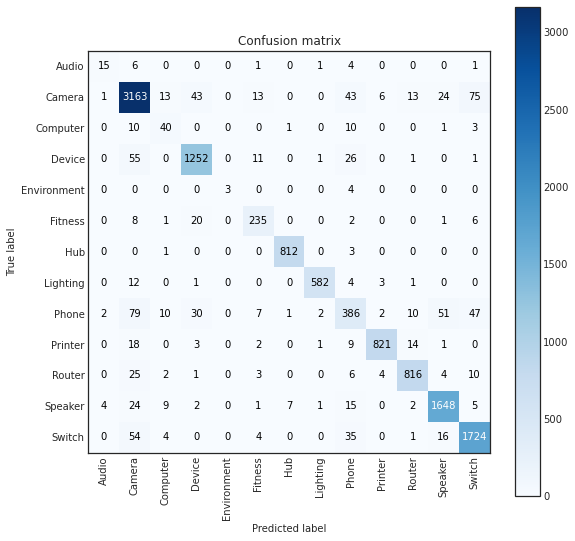

In [47]:
plt.figure(figsize=(9,9))
classes = [labels_pdf.loc[labels_pdf.category_id == c,'category'].values[0] for c in test_Y['category_id'].unique()]
plot_confusion_matrix(cm,classes)
plt.show()

This is an interesting plot. One can observe that Camera, Speaker and Phone are more commonly confused devices, while hubs, printers and routers are less confused.

### Plotting the ROC Curves

Receiver Operating Characteristic or ROC is a commonly used graph that summarizes the performance of a classifier over all possible thresholds. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class.

A <b>ROC</b> curve is inirialy designed for binary classification. Here we use ROC curve analysis for multiclass problems. We do this by looking at the ROC curve for each class. 

Lots of code below, but it's fairly straightofrward and [adapted from an example in the scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings). Before we plot though, we'll create a simple category lookup dictionary so we can label the classes with their actual names (not their category IDs).

In [48]:
test_Y_binarize = label_binarize(test_Y.to_pandas(), classes=np.arange(param['num_class']))

print("==> length of probs =",len(probs))
print("==> length of test_Y_binarize =", len(test_Y_binarize))

==> length of probs = 12456
==> length of test_Y_binarize = 12456


Some more housekeeping. We'll create Python dictionaries to hold FPR, TPR, and AUC values.

In [49]:
fpr = dict()
tpr = dict()
roc_auc = dict()

For each of our classes, we'll computer FPR, TPR, and AUC. We're also compute the [micro and macro averages](http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html).

In [50]:
print("==> number of classes =", num_categories)

==> number of classes = 13


In [51]:
# calculate FPR, TPR, and ROC AUC for every class
for i in range(num_categories):
    fpr[i], tpr[i], _ = roc_curve(test_Y_binarize[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# calculate the micro average FPR, TPR, and ROC AUC (we'll calculate the macro average below)
fpr["micro"], tpr["micro"], _ = roc_curve(test_Y_binarize.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [52]:
category_lookup = labels_pdf[['category','category_id']].drop_duplicates().set_index('category_id').T.to_dict()

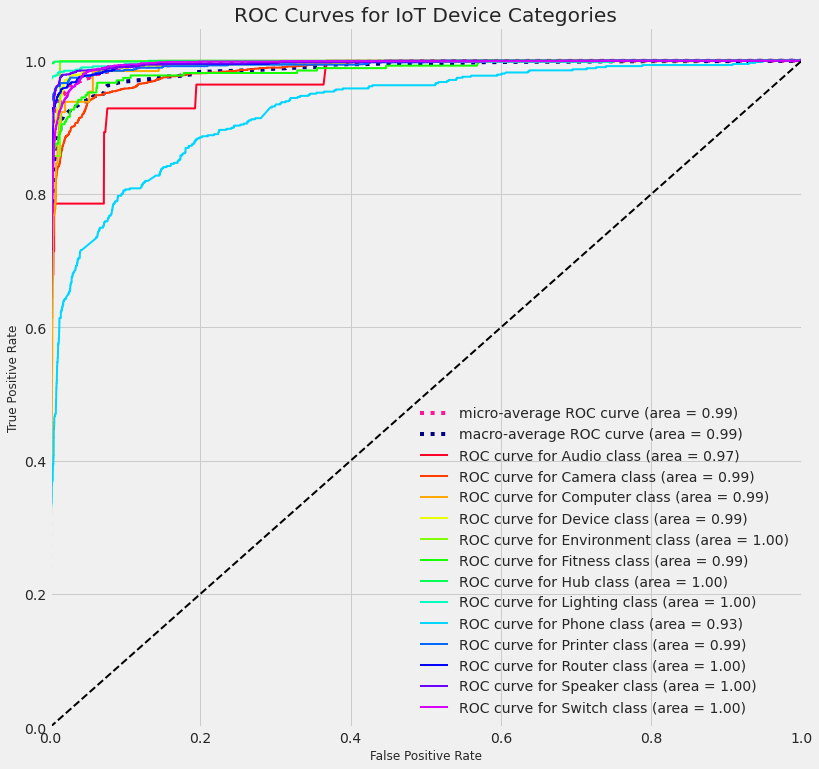

In [53]:
plt.style.use('fivethirtyeight')
# aggregate all of the false positive rates across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_categories)]))

# interpolate all of the ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(param['num_class']):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average the TPR
mean_tpr /= num_categories

# compute the macro average FPR, TPR, and ROC AUC
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# plot all of the ROC curves on a single plot (for comparison)
plt.figure(figsize=(12,12))
plt.plot(fpr['micro'], tpr['micro'],
         label="micro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label="macro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

num_colors = param['num_class']
cm = plt.get_cmap('gist_rainbow')

colors = cycle([cm(1.*i/num_colors) for i in range(num_colors)])

lw = 2
for i, color in zip(range(param['num_class']), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label="ROC curve for "+category_lookup[i]['category']+" class (area = {1:0.2f})"
             "".format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for IoT Device Categories")
plt.legend(loc="lower right")
plt.show()

We can also plot each class as its own subplot.

First we make a few variables so we can control the layout.

In [54]:
total_subplots = num_categories
plot_grid_cols = 3
plot_grid_rows = total_subplots // plot_grid_cols
plot_grid_rows += total_subplots % plot_grid_cols

position_index = range(1, total_subplots+1)

Now we make the grid of plots.

<Figure size 432x288 with 0 Axes>

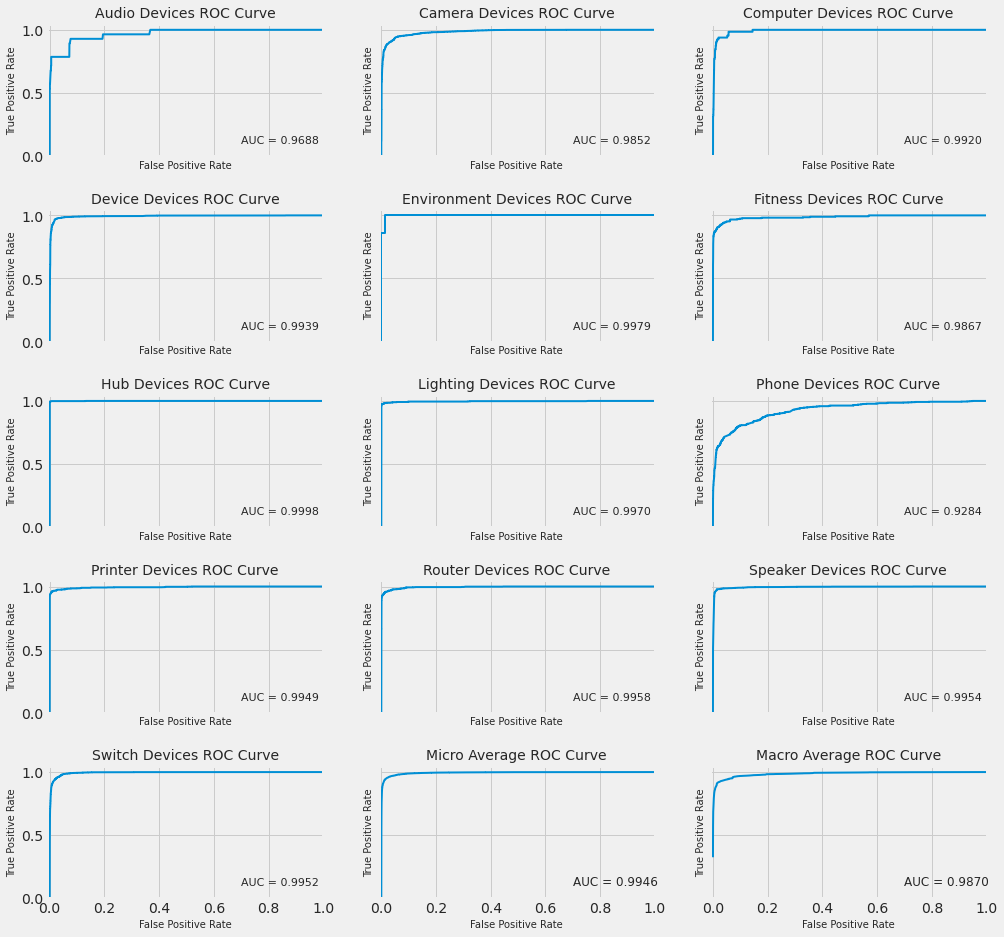

In [55]:
plt.figure()
fig, axs = plt.subplots(plot_grid_rows, plot_grid_cols, sharex=True, sharey=True, figsize=(15,15))

lw = 2

plt_num = 0
for row in range(plot_grid_rows):
    for col in range(plot_grid_cols):
        if(plt_num <= 12):
            axs[row,col].plot(fpr[plt_num], tpr[plt_num], lw=lw)
            axs[row,col].set_title(category_lookup[plt_num]['category']+' Devices ROC Curve', fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc[plt_num]), size=11)
        elif(plt_num == 13):
            axs[row,col].plot(fpr['micro'], tpr['micro'], lw=lw)
            axs[row,col].set_title("Micro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['micro']), size=12)
        elif(plt_num == 14):
            axs[row,col].plot(fpr['macro'], tpr['macro'], lw=lw)
            axs[row,col].set_title("Macro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['macro']), size=12)
        axs[row,col].set_xlabel('False Positive Rate', fontsize=10)
        axs[row,col].set_ylabel('True Positive Rate', fontsize=10)
        plt_num += 1
            
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### Conclusions 
Thank you for attending the class and following along with this tutorial. During the course of this tutorial we have:

- Described a real-world use case for AI in cyber
- Used statistical analysis to explore our PCAP data
- Demonstrated techniques to predict Network Device Types

and attempted to show that statistical analysis techniques and machine learning can play a critical role in enhancing the abilities of cyber security professionals. 

Furthermore, we hope that we have educated the student in the understanding of what is needed (BigData) to get to a state where machine learning can be applied to real-world cyber security issues. 

Please use this tutorial as a basic introduction to applying machine learning to your issues while you continue to explore the implementation or artificial intelligence.   

### Acknowledgments and References
We woud like to acknowledge the people and papers that have influenced our work. Thank you all!

We would like to thank the authors and contributors to the [KDD 2019 Hand-On Tutorial](https://github.com/BartleyR/notebooks-extended/blob/master/conference_notebooks/KDD_2019/notebooks/KDD-Cyber.ipynb), upon which this extended tutorial notebook was built:
 - Rachel Allen, PhD (NVIDIA) [rachela@nvidia.com]
 - Haekyu Park (Georgia Tech, NVIDIA)
 - Bartley Richardson, PhD (NVIDIA) [brichardson@nvidia.com]

1. Richardson, B., Rhoades, B., et. all,  "Classification of IoT Flow Data using RAPIDS and XGBoost", *GTC DC 2019*, https://github.com/BartleyR/notebooks-extended/tree/master/blog_notebooks/cyber/flow_classification 
1. Nadji, Y., "Passive DNS-based Device Identification", *NANOG 67*, https://www.nanog.org/sites/default/files/Nadji.pdf.
1. Shams, R., "Micro- and Macro-average of Precision, Recall, and F-Score", http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html.
1. Sivanathan, A. et al., "Characterizing and Classifying IoT Traffic in Smart Cities and Campuses", *2017 IEEE Conference on Computer Communications Workshops*, May 2017, http://www2.eet.unsw.edu.au/~vijay/pubs/conf/17infocom.pdf.
1. University of New South Wales Internet of Things Network Traffic Data Collection, http://149.171.189.1